In [1]:
pip list

Package                       Version
----------------------------- -------------------
alabaster                     0.7.12
anyio                         3.3.4
argon2-cffi                   21.1.0
async-generator               1.10
attrs                         21.2.0
Babel                         2.9.1
backcall                      0.2.0
backports.functools-lru-cache 1.6.4
beautifulsoup4                4.10.0
bleach                        4.1.0
brotlipy                      0.7.0
certifi                       2021.10.8
cffi                          1.15.0
cftime                        1.5.1.1
chardet                       4.0.0
charset-normalizer            2.0.0
click                         7.1.2
click-completion              0.5.2
click-log                     0.3.2
click-plugins                 1.1.1
cligj                         0.7.1
cloudpickle                   1.6.0
colorama                      0.4.4
cryptography                  35.0.0
cycler                        0.10.0


spyder-kernels                1.10.2
SQLAlchemy                    1.4.26
terminado                     0.12.1
testpath                      0.5.0
toml                          0.10.2
tornado                       6.1
traitlets                     5.0.5
typing-extensions             3.10.0.2
uc-micro-py                   1.0.1
urllib3                       1.26.7
wcwidth                       0.2.5
webencodings                  0.5.1
websocket-client              0.57.0
wheel                         0.36.2
widgetsnbextension            3.5.2
win-inet-pton                 1.1.0
wincertstore                  0.2
zipp                          3.6.0


In [2]:
import numpy as np
import gdal
import pandas as pd
import os
import glob
import math
from scipy.stats import iqr
import geopandas as gpd
from pathlib import Path
import warnings

from ll2ps_projection import stereosouth_lonlat2xy# for lon/lat to xy projection (see stereosouth_xy2lonlat function)

In [3]:
# Opening reference GeoTIFF and get relevant parameters
refIm = "input_grid/BEDMAP3_shapefile_processing_Input_extent500x500_crop.tif" 
ds = gdal.Open(refIm)
ar = ds.GetRasterBand(1).ReadAsArray()
gt = ds.GetGeoTransform()
res = gt[1]
xmin = gt[0]
ymax = gt[3]
xsize = ds.RasterXSize
ysize = ds.RasterYSize
ds = None
xstart = xmin + res/2 
ystart = ymax - res/2

# Create array of x and y values at the centre of each pixel
x = np.arange(xstart, xstart + xsize * res, res)
y = np.arange(ystart, ystart -ysize * res, -res )

In [4]:
values = np.empty((xsize,ysize,), dtype = np.dtype(list))

In [5]:
lon_point = [] #longitude points from csv file
lat_point = [] #latitude points from csv file
ice_thickness = [] #ice thickness points from csv file
surfElev = [] #surf elev points from csv file
bedElev = [] #bed elev points from csv file
index = [] #will give index for x and y where there are data in csv file

In [6]:
def read_Aerogeophysics(input_file, lon, lat, ice_thickness, surfElev, bedElev):
    "Function to read bed elevation picks data in the standardised format"
    print('file name: %s' %input_file) #print filename of file processed   
    data = pd.read_csv(input_file, skiprows=18) #open input file 
    Lat_i= [variable for variable in data.columns.tolist() if (variable.startswith('latitude'))][0] #latitude WGS84 data
    Lon_i = [variable for variable in data.columns.tolist() if (variable.startswith('longitude'))][0] #Longitude WGS84 data
    ice_i = [variable for variable in data.columns.tolist() if (variable.startswith('land_ice'))][0] #ice thickness WGS84 data
    surf_i = [variable for variable in data.columns.tolist() if (variable.startswith('surface'))][0] #surf elev WGS84 data
    bed_i = [variable for variable in data.columns.tolist() if (variable.startswith('bed'))][0] #bed elev WGS84 data
    for i in range(1, len(data)): #To select only data with ice thickness, bed or surface elevation values
        if data[ice_i][i] > -9000 or data[surf_i][i] > -9000 or data[bed_i][i] > -9000:
            ice_thickness.append(float(data[ice_i][i]))
            surfElev.append(float(data[surf_i][i]))
            bedElev.append(float(data[bed_i][i]))
            lon.append(float(data[Lon_i][i]))
            lat.append(float(data[Lat_i][i]))
    return lat, lon, ice_thickness, surfElev, bedElev #give latitude, longitude (WGS84, decimal degree) and ice thickness from file. -9999 values are excluded


In [7]:
aerogeophysics_data = 'D:/BEDMAP/AWI_2015_GEA-DML_AIR_BM3.csv'
ID = aerogeophysics_data.split('/')[-1].strip('.csv')
ID_split = ID.split('_')
lat_point, lon_point, ice_thickness, surfElev, bedElev  = read_Aerogeophysics(aerogeophysics_data, lon_point, lat_point, ice_thickness, surfElev, bedElev) #To comment if calculating at the data provider level

file name: D:/BEDMAP/AWI_2015_GEA-DML_AIR_BM3.csv


In [8]:
lonpolar, latpolar = stereosouth_lonlat2xy(lon_point, lat_point)
lonpolar, latpolar = lonpolar*1000, latpolar*1000 #To convert in meters

In [9]:
def Distance(x1, y1, x2, y2):
    "To calculate the distance between 2 points"
    dist = math.sqrt((x1-x2)*(x1-x2) + (y1-y2)*(y1-y2))
    return dist 

for j in range(0, len(lat_point)):
    indlat = int(round(abs(latpolar[j] - y[0])/500)) #To get latitude index
    indlon = int(round(abs(lonpolar[j] - x[0])/500)) #To get longitude index
    dist = Distance(x[indlon], y[indlat], lonpolar[j], latpolar[j]) #Calculate the distance between the latitude, longitude from csv file to x,y from the reference image
    if values[indlon][indlat] == None: #When this is the first point to be added to the variable values
        values[indlon][indlat] = [[x[indlon], y[indlat], lonpolar[j], latpolar[j], lon_point[j], lat_point[j], ice_thickness[j], surfElev[j], bedElev[j], dist]]
        index.append([indlon, indlat])
    else:
        values[indlon][indlat].append([x[indlon], y[indlat], lonpolar[j], latpolar[j], lon_point[j], lat_point[j], ice_thickness[j], surfElev[j], bedElev[j], dist])


In [10]:
point_values = []
for k in range(0, len(index)):
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=RuntimeWarning)
        df_temp = pd.DataFrame(values[index[k][0]][index[k][1]])
        df_temp_nan = df_temp.replace(-9999.0, np.nan)
        mean_dist = round(df_temp_nan[9].mean()) # mean distance to the point
        df_points = len(df_temp)
        
        #Ice thickness statistics
        mean_thick = -9999 if math.isnan(df_temp_nan[6].mean()) else round(df_temp_nan[6].mean()) #mean of ice thickness
        median_thick = -9999 if math.isnan(df_temp_nan[6].median()) else round(df_temp_nan[6].median()) #median for ice thickness        
        iqr_thick = -9999 if math.isnan(iqr(df_temp[6][df_temp[6] != -9999.])) else round(iqr(df_temp[6][df_temp[6] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_thick = -9999 if math.isnan(df_temp_nan[6].min()) else round(df_temp_nan[6].min()) #minimum value of ice thickness at the specific point
        max_thick = -9999 if math.isnan(df_temp_nan[6].max()) else round(df_temp_nan[6].max()) #maximum value of ice thickness at the specific point
        nb_point_thick = df_points - df_temp[6][df_temp[6] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[6].std()):
            std_thick = -9999
            SE_thick = -9999
        else:
            std_thick = round(df_temp_nan[6].std()) #standard deviation if ice thickness values at the specific point
            SE_thick = std_thick/np.sqrt(nb_point_thick)
            
        #Bed elevation statistics
        mean_bed = -9999 if math.isnan(df_temp_nan[8].mean()) else round(df_temp_nan[8].mean()) #mean of ice thickness
        median_bed = -9999 if math.isnan(df_temp_nan[8].median()) else round(df_temp_nan[8].median()) #median for ice thickness
        iqr_bed = -9999 if math.isnan(iqr(df_temp[8][df_temp[8] != -9999.])) else round(iqr(df_temp[8][df_temp[8] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_bed = -9999 if math.isnan(df_temp_nan[8].min()) else round(df_temp_nan[8].min()) #minimum value of ice thickness at the specific point
        max_bed = -9999 if math.isnan(df_temp_nan[8].max()) else round(df_temp_nan[8].max()) #maximum value of ice thickness at the specific point
        nb_point_bed = df_points - df_temp[8][df_temp[8] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[8].std()):
            std_bed = -9999
            SE_bed = -9999
        else:
            std_bed = round(df_temp_nan[8].std()) #standard deviation if ice thickness values at the specific point
            SE_bed = std_bed/np.sqrt(nb_point_bed)
            
        #Surface elevation statistics
        mean_surf = -9999 if math.isnan(df_temp_nan[7].mean()) else round(df_temp_nan[7].mean()) #mean of ice thickness
        median_surf = -9999 if math.isnan(df_temp_nan[7].median()) else round(df_temp_nan[7].median()) #median for ice thickness
        iqr_surf = -9999 if math.isnan(iqr(df_temp[7][df_temp[7] != -9999.])) else round(iqr(df_temp[7][df_temp[7] != -9999.])) # IQR range for value of ice thickness at the specific point
        min_surf = -9999 if math.isnan(df_temp_nan[7].min()) else round(df_temp_nan[7].min()) #minimum value of ice thickness at the specific point
        max_surf = -9999 if math.isnan(df_temp_nan[7].max()) else round(df_temp_nan[7].max()) #maximum value of ice thickness at the specific point
        nb_point_surf = df_points - df_temp[7][df_temp[7] == -9999.].shape[0] #to calculate the number of points used to calculate the ice thickness at the specific point 
        std_surf = df_temp_nan[7].std()
        if len(values[index[k][0]][index[k][1]])==1 or math.isnan(df_temp_nan[7].std()):
            std_surf = -9999
            SE_surf = -9999
        else:
            std_surf = round(df_temp_nan[7].std()) #standard deviation if ice thickness values at the specific point
            SE_surf = std_surf/np.sqrt(nb_point_surf)
            
        point_values.append([float(x[index[k][0]]), float(y[index[k][1]]), 
                             mean_thick, median_thick, std_thick, nb_point_thick, iqr_thick, SE_thick, min_thick, max_thick,
                             mean_surf, median_surf, std_surf, nb_point_surf, iqr_surf, SE_surf, min_surf, max_surf,
                             mean_bed, median_bed, std_bed, nb_point_bed, iqr_bed, SE_bed, min_bed, max_bed, mean_dist])


In [11]:
columns = ['Lon', 'Lat',
           'Mean_thick_m', 'Med_thick_m', 'SD_thick', 'Count_thick', 'IQR_thick', 'STE_thick', 'Min_thick_m', 'Max_thick_m', 
           'Mean_surf_m', 'Median_surf_m', 'SD_surf', 'Count_surf', 'IQR_surf', 'STE_surf', 'Min_surf_m', 'Max_surf_m', 
           'Mean_bed_m', 'Median_bed_m', 'SD_bed', 'Count_bed', 'IQR_bed', 'STE_bed', 'Min_bed_m', 'Max_bed_m', 'Mean_dist_m']
df = pd.DataFrame(point_values, columns = columns, dtype='int16') #dataframe containing all the values
df.head()

,Lon,Lat,Mean_thick_m,Med_thick_m,SD_thick,Count_thick,IQR_thick,STE_thick,Min_thick_m,Max_thick_m,...,Max_surf_m,Mean_bed_m,Median_bed_m,SD_bed,Count_bed,IQR_bed,STE_bed,Min_bed_m,Max_bed_m,Mean_dist_m
0,-209750.0,2069250.0,458,456,6,3,6,3.464102,453,464,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,230
1,-209250.0,2068750.0,445,445,-9999,1,0,-9999.000000,445,445,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,183
2,-208750.0,2068750.0,434,434,1,3,1,0.577350,432,434,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,143
3,-208250.0,2068750.0,420,420,9,2,6,6.363961,414,426,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,131
4,-207750.0,2068750.0,397,397,-9999,1,0,-9999.000000,397,397,...,-9999,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,265


In [12]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Lon, df.Lat), dtype='int16') #Transformation of the dataframe to a geodataframe
gdf = gdf.drop(columns=['Lon', 'Lat']) #To not have Lat and Lon in the attributes of the shapefile/geopackage
gdf = gdf.set_crs("EPSG:3031") #Set the coordinate system
gdf.head()

,Mean_thick_m,Med_thick_m,SD_thick,Count_thick,IQR_thick,STE_thick,Min_thick_m,Max_thick_m,Mean_surf_m,Median_surf_m,...,Mean_bed_m,Median_bed_m,SD_bed,Count_bed,IQR_bed,STE_bed,Min_bed_m,Max_bed_m,Mean_dist_m,geometry
0,458,456,6,3,6,3,453,464,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,230,POINT (-209750.000 2069250.000)
1,445,445,-9999,1,0,-9999,445,445,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,183,POINT (-209250.000 2068750.000)
2,434,434,1,3,1,0,432,434,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,143,POINT (-208750.000 2068750.000)
3,420,420,9,2,6,6,414,426,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,131,POINT (-208250.000 2068750.000)
4,397,397,-9999,1,0,-9999,397,397,-9999,-9999,...,-9999,-9999,-9999,0,-9999,-9999,-9999,-9999,265,POINT (-207750.000 2068750.000)


In [13]:
variables_int = gdf.columns.tolist()
variables_int.remove('geometry')
schema = gpd.io.file.infer_schema(gdf)
for k in range(0, len(variables_int)):
    schema['properties'][variables_int[k]] = 'int32'

print('creation of files')
gdf.to_file('D:/BEDMAP/%s_points.gpkg' %ID, layer='Point_%s' %ID.replace('-', ''), driver="GPKG",  schema=schema) #To save as geopackage
#gdf.to_file('shapefile_processing/output/%s_points.shp' %ID, driver="ESRI Shapefile",  schema=schema) #To save as a shapefile


creation of files


In [14]:
# This line configures matplotlib to show figures embedded in the notebook, 
# instead of opening a new window for each figure. More about that later. 
# If you are using an old version of IPython, try using '%pylab inline' instead.
%matplotlib inline

In [15]:
import matplotlib
import matplotlib.pyplot as plt

<AxesSubplot:>

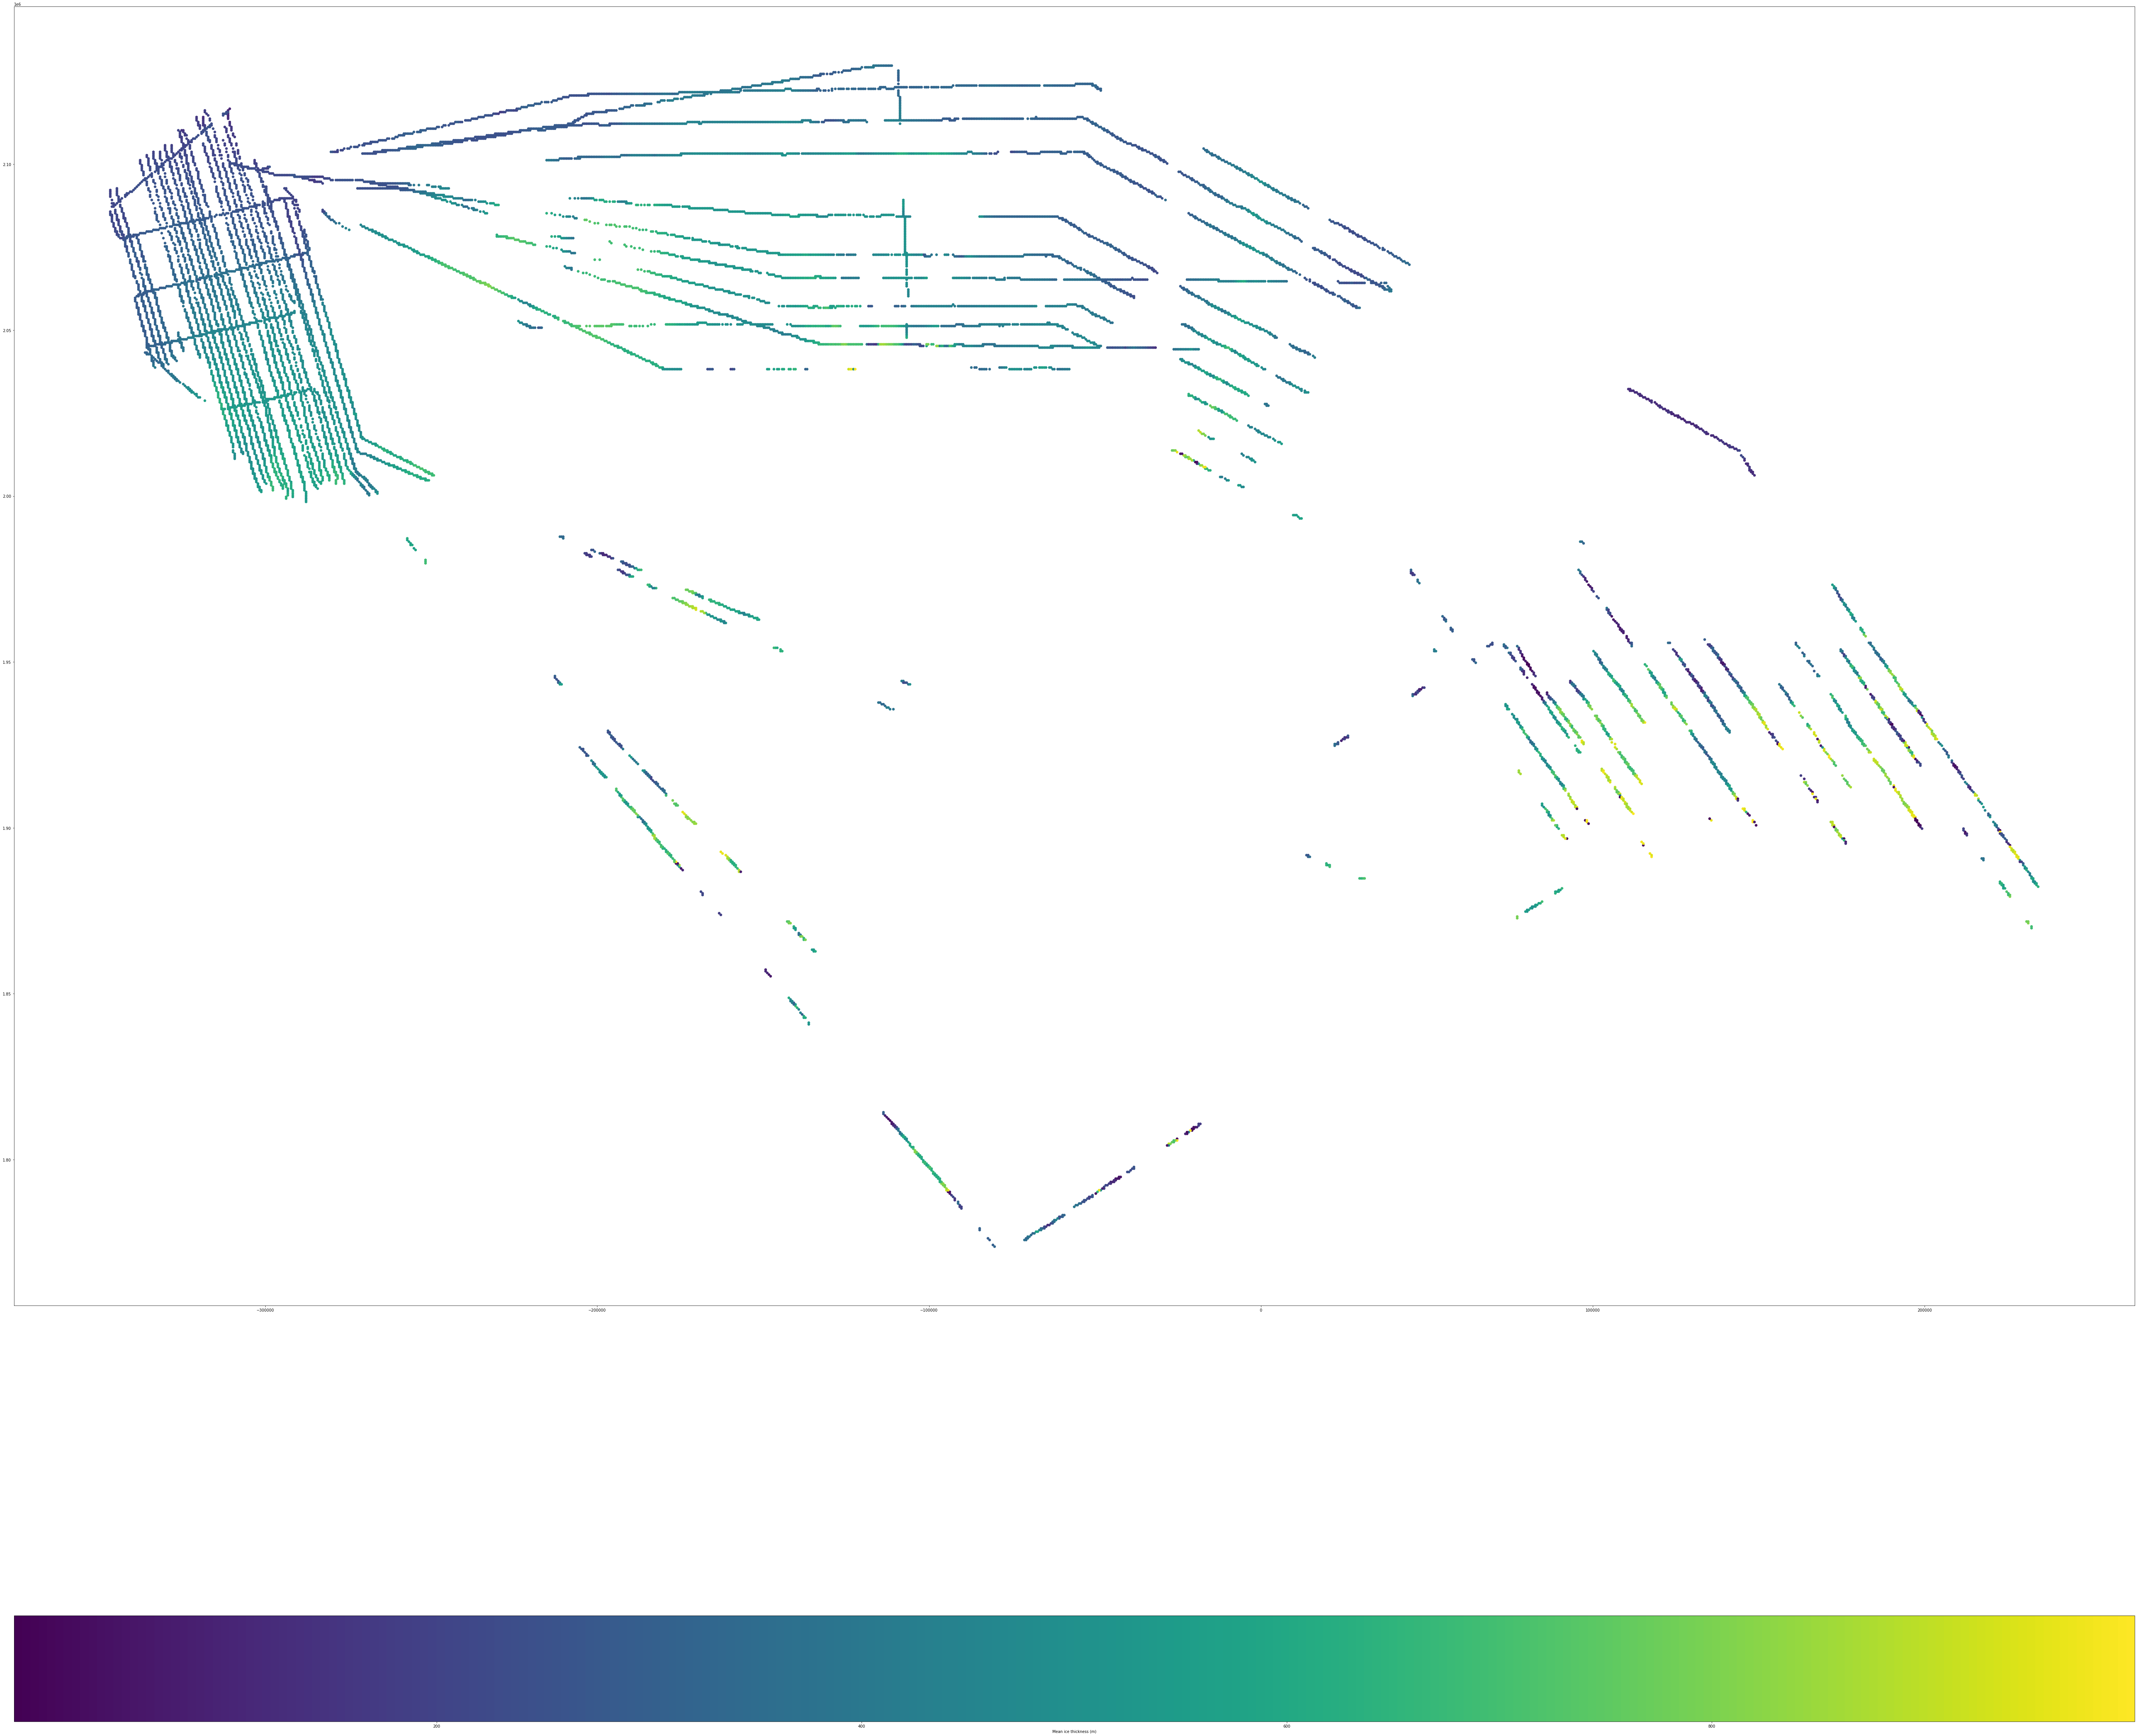

<Figure size 2000x2000 with 0 Axes>

In [16]:
plt.rcParams["figure.figsize"] = (100,100)
fig, ax = plt.subplots(1, 1)
fig=plt.figure(figsize=(20,20), dpi= 100, facecolor='w', edgecolor='k')
gdf.plot(column='Mean_thick_m', ax=ax, legend=True, legend_kwds={'label': "Mean ice thickness (m)",'orientation': "horizontal"})